Проверка зятя на отцовство внука :)

## Задание
Обучить детектор объектов с помощью TensorFlow Object Detection API.

Библиотеки: [Python, Tensorflow]

## План решения
[0. Установка TensorFlow Object Detection API](#section_0)

[1. Вспомогательные функции](#section_1)

[2. Загрузка и визуализация тренировочных данных](#section_2)

[3. Подготовка данных для обучения](#section_3)
    
[4. Загрузка предобученной модели](#section_4)
    
[5. Дообучение модели](#section_5)
    
[6. Оценка качества модели](#section_6)

TensorFlow Object Detection API (https://github.com/tensorflow/models/tree/master/research/object_detection) -- это платформа с открытым исходным кодом, построенная поверх TensorFlow, которая упрощает создание, обучение и развертывание моделей детектирования объектов.

TensorFlow Object Detection API поддерживает как TensorFlow 2 (TF2), так и TensorFlow 1 (TF1). Будем использовать Object Detection API TensorFlow 2 (https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md).

### 0. Установка TensorFlow Object Detection API i <a id='section_0'></a>

In [1]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 8.8 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.

In [2]:
#Клонирование tensorflow репозитория в директорию models 
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 76648, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 76648 (delta 231), reused 420 (delta 210), pack-reused 76179
Receiving objects: 100% (76648/76648), 596.83 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (54318/54318), done.


In [3]:
#Установка Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1695009 sha256=0cdd949299386898c0d5845ced571180518835294ba8ea9bae91c41be23e2a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-xz6w12hc/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=2f5048589d8bd07b47aef0407d20a628a7810d078b2c0fc3f0d238f73d696ffa
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=9a75f1e65b64ea16cd1bb1cdd4701cd658de6a5d6fbff80907d53ef0c9c2a805
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_p

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [4]:
#Импорт необходимых библиотек и модулей
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

### 1. Вспомогательные функции <a id='section_1'></a>

In [5]:
def load_image_into_numpy_array(path):
  """Загрузка изображений из файла в массив numpy.

    Помещает изображение в массив numpy для подачи в граф tensorflow.
    Массив numpy имеет форму (высота, ширина, каналы), где каналы =3 для RGB.

    Аргументы:
    path: путь к файлу.

    Возвращается:
    uint8 числовой массив с формой (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data)) #для работы с необработанными байтами вместо текста Unicode необходимо использовать io.BytesIO
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Функция-оболочка для визуализации детекции.

     Аргументы:
    image_np: uint8 числовой массив с формой (img_height, img_width, 3)
    boxes: числовой массив формы [N, 4]
    classes: числовой массив формы [N]. Обратите внимание, что индексы классов основаны на 1
               и соответствуют ключам в карте меток.
    scores: числовой массив формы [N] или None. Если scores = None, то
            эта функция предполагает, что поля, которые будут нанесены на график, 
            являются базовыми боксами и будут нарисованы черным без каких-либо классов или оценок.
     category_index: dict, содержащий словари категорий (каждый из которых содержит
                     category index `id` и category name `name`), 
                     определяемые индексами категорий.
    figsize: размер фигуры.
    image_name: имя файла изображения.
  """
  image_np_with_annotations = image_np.copy()
  #наложение помеченных полей на изображение с отформатированными оценками и названиями меток 
  #(функция из https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.1)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations) #сохранение массива image_np_with_annotations как изображения c имененим image_name
  else:
    plt.imshow(image_np_with_annotations) #отображение данных как изображения

### 2. Загрузка  и визуализация тренировочных данных <a id='section_2'></a>


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Загрузка данных и визуализация
train_image_dir = '/content/drive/MyDrive/Colab Notebooks/CV/images/train'
train_images_np = [] #список имен файлов
for i in range(2, 19):
  image_path = os.path.join(train_image_dir, str(i) + '.jpeg')
  train_images_np.append(load_image_into_numpy_array(image_path))

#динамически изменяем настройки
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

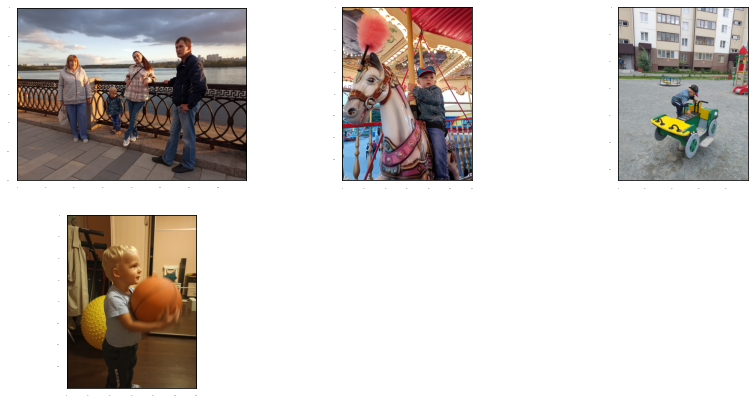

In [8]:
for idx, train_image_np in enumerate(train_images_np[:4]):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [9]:
#создание ограничивающих рамок в ручную
#gt_boxes = []
#colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [10]:
gt_boxes = [np.array([[0.44938889, 0.38      , 0.75272222, 0.465625  ]], dtype=np.float32),
 np.array([[0.30772222, 0.48405496, 1.        , 0.83376354]], dtype=np.float32),
 np.array([[0.43605555, 0.40416667, 0.64938889, 0.621875  ]], dtype=np.float32),
 np.array([[0.15438889, 0.25645296, 0.98438889, 0.88592839]], dtype=np.float32),
 np.array([[0.33605555, 0.29375   , 1.        , 0.52625   ]], dtype=np.float32),
 np.array([[0.25438889, 0.36458333, 0.81938889, 0.64791667]], dtype=np.float32),
 np.array([[0.00605555, 0.271875  , 0.77938889, 0.78958333]], dtype=np.float32),
 np.array([[0.16605555, 0.284375  , 0.80105555, 0.82708333]], dtype=np.float32),
 np.array([[0.25438889, 0.38634471, 0.60938889, 0.53871774]], dtype=np.float32),
 np.array([[0.33105555, 0.14820983, 0.87105555, 0.4304746 ]], dtype=np.float32),
 np.array([[0.31105555, 0.41382182, 0.95772222, 0.70191507]], dtype=np.float32),
 np.array([[0.42105555, 0.36136553, 0.69272222, 0.49042465]], dtype=np.float32),
 np.array([[0.31438889, 0.42214821, 0.62272222, 0.78351374]], dtype=np.float32),
 np.array([[0.32772222, 0.08992506, 1.        , 0.64363031]], dtype=np.float32),
 np.array([[0.00438889, 0.01833333, 0.72772222, 0.62333333]], dtype=np.float32),
 np.array([[0.22272222, 0.36885928, 0.77605555, 0.68276436]], dtype=np.float32),
 np.array([[0.16938889, 0.61128527, 0.61438889, 0.82445141]], dtype=np.float32)]

In [6]:
#ограничивающие рамки изображений
"""
_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]
"""

### 3. Подготовка данных для обучения <a id='section_3'></a>
Добавляем аннотации классов и преобразуем все в формат, который ожидает приведенный ниже цикл обучения (например, все преобразуется в тензоры, классы преобразуются в одномерные представления и т.д.).

In [11]:
# Будем использовать только один класс, поэтому используем 'class id' = 1.
vanya_class_id = 1
num_classes = 1

category_index = {vanya_class_id: {'id': vanya_class_id, 'name': 'vanya'}}

# Преобразуем метки классов
#(`label_id_offset` сдвигает все классы на определенное количество индексов,
#чтобы модель получала one-hot метки, где нет фона (классы начинают отсчет с нулевого индекса)
#Преобразуем все в тензоры
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  #возвращаем тензор, где 0-размерности стоит 1
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  #тензор из нулей
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  #возвращаем one-hot тензор len(zero_indexed_groundtruth_classes)*num_classes
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


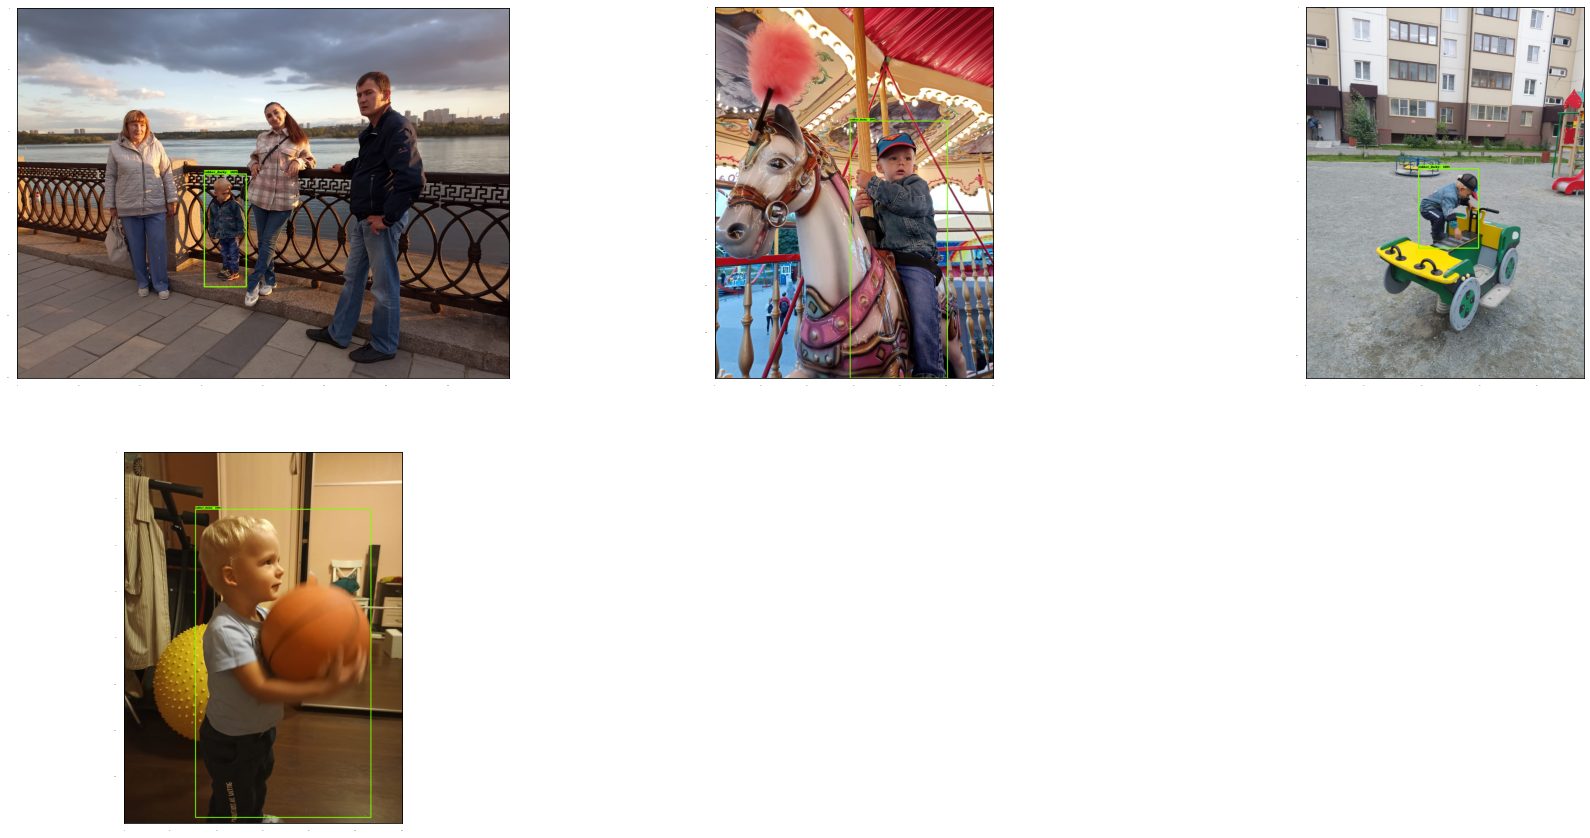

In [12]:
#Визуализация
dummy_scores = np.array([1.0], dtype=np.float32)  # бокс для score 100%

plt.figure(figsize=(30, 15))
for idx in range(4):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

### 4. Загрузка предобученной модели <a id='section_4'></a>

In [13]:
#Загрузка контрольную точку и помещение ее в models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-08-31 12:31:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   181MB/s    in 1.3s    

2022-08-31 12:31:13 (181 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [14]:
#Сбрасываем все состояния, сгенерированные Keras
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
#Переопределяем `num_classes` на 1 (для нового rubber ducky класса), поскольку исходная архитектура COCO предсказываем 90 классов
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

#Загружаем конфигурацию пайплайна и строим модель детекции объектов
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

# Настройка восстановления up object-based checkpoint restore --- RetinaNet имеет два предсказания
# `heads` --- один для классификации, другой для box регрессии. Мы будем
# восстанавливать head box регрессии, но инициализировать head классификации 
# из scratch (закомментированные строки позволяют восстановить обе heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (head классификции, которую мы не восстанавливаем)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
#Управляем сохранением/восстановлением отслеживаемых значений на диске
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

#Запускаем модель через фиктивное изображение, чтобы были созданы переменные
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


### 5. Дообучение модели <a id='section_5'></a>

#  Дообучил модель с learning_rate = 0.001 на num_batches = 50, 1-й цикл обучал с learning_rate = 0.01 на num_batches = 100, лосс скакал.

In [19]:
#Устанавливаем фазу обучения на фиксированное значение
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.001
num_batches = 50

# Выбираем параметры в последнем слое для настройки
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Настрока forward + backward pass дляодного шага обучения
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Получение tf.function для шага обучения"""
  #Используем tf.function для увеличения скорости
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """Одна обучающая итерация

    Args:
      image_tensors: Список тензоров [1, высота, ширина, 3] типа tf.float32.
      (высота и ширина могут варьироваться в зависимости от изображений, поскольку
        в рамках этой функции они изменяются на 640x640)
      groundtruth_boxes_list: Список тензоров формы [N_i, 4] типа tf.float32,
      представляющий истинные боксы для каждого изображения в батче.
      groundtruth_classes_list: Список тензоров формы [N_i, num_classes] типа tf.float32, 
      представляющий groundtruth боксы для каждого изображения в батче.

    Возвращается:
      Скалярный тензор, представляющий общий лосс для входного батча.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # создание ключение для случайного подмножества примеров
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Шаг обучения (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 50, loss=0.044285048


batch 10 of 50, loss=0.01814314
batch 20 of 50, loss=0.021271853
batch 30 of 50, loss=0.040209647
batch 40 of 50, loss=0.011642974
Done fine-tuning!


### 6. Оценка качества модели <a id='section_6'></a>

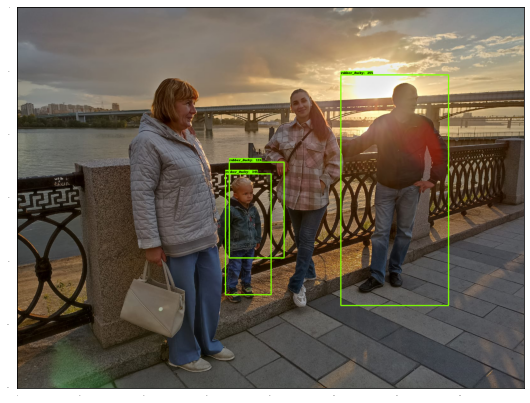

In [20]:
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/CV/images/test/'
test_images_np = [] #список numpy array картинок
for i in [99]:
  image_path = os.path.join(test_image_dir, str(i) + '.jpeg')
  test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

@tf.function
def detect(input_tensor):
  """Запуск детекции на входном изображении.

  Аргументы:
    input_tensor: Тензор [1, высота, ширина, 3] типа tf.float32.
                 (высота и ширина могут быть любыми, поскольку размер изображения все арвно будет изменен)

  Возвращается:
    Словарь из 3 тензоров (`detection_boxes`, `detection_classes`, and `detection_scores`).
  """
  #1. предварительная обработка (масштабирование, обрезка. поворот и т.д.)
  #(на вход: тензор [batch, height_in, width_in, channels] float32 от 0 до 255.0.)
  #(на выход: тензор изображения [batch, height_out, width_out, channels] float32,
  #           тензор true_image_shapes: int32 tensor of shape [batch, 3],
                     #где каждая строка имеет форму [height, width, channels] указывающая формы истинных изображений
                     #в измененных изображениях)
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  #№2.предсказываем тензоры из входных тензоров
  #(на вход: тензор батча [batch, height, width, channels] типа float32,
  #          тензор размеров истинных изображений int32 tensor или [batch, 3],
  #          где каждая строка [height, width, channels] указывает форму истинных изображений в измененных)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  #3.преобразуем предсказанные тензоры в финальную детекцию
  #(на вход: словарь, содержащий тензоры предсказаний,
  #          тензор размеров истинных изображений int32 tensor или [batch, 3],
  #          где каждая строка [height, width, channels] указывает форму истинных изображений в измененных) 
  #(на выход: словарь с полями detection_boxes, detection_scores, detection_classes, detection_masks,
  #           detection_keypoints, detection_keypoint_scores, detection_surface_coords, num_detections)
  return detection_model.postprocess(prediction_dict, shapes)

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      # category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")
      category_index, figsize=(15, 20), image_name=None)

In [22]:
"""
input_tensor = tf.convert_to_tensor(test_images_np[1], dtype=tf.float32)
detections = detect(input_tensor)

plot_detections(
     test_images_np[1][0],
     detections['detection_boxes'][0].numpy(),
     detections['detection_classes'][0].numpy().astype(np.uint32)
     + label_id_offset,
     detections['detection_scores'][0].numpy(),
     # category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")
     category_index, figsize=(15, 20), image_name=None)
"""

'\ninput_tensor = tf.convert_to_tensor(test_images_np[1], dtype=tf.float32)\ndetections = detect(input_tensor)\n\nplot_detections(\n     test_images_np[1][0],\n     detections[\'detection_boxes\'][0].numpy(),\n     detections[\'detection_classes\'][0].numpy().astype(np.uint32)\n     + label_id_offset,\n     detections[\'detection_scores\'][0].numpy(),\n     # category_index, figsize=(15, 20), image_name="gif_frame_" + (\'%02d\' % i) + ".jpg")\n     category_index, figsize=(15, 20), image_name=None)\n'

In [23]:
#визуализация предсказаний gif-ками

#считывание/запись изображений с помощью FreeImage
"""
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif' #имя файла gif

#список имен файлов
filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = [] #изображения для gif
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

#сохраняем серию изображений как gif
imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))
"""


"\nimageio.plugins.freeimage.download()\n\nanim_file = 'duckies_test.gif' #имя файла gif\n\n#список имен файлов\nfilenames = glob.glob('gif_frame_*.jpg')\nfilenames = sorted(filenames)\nlast = -1\nimages = [] #изображения для gif\nfor filename in filenames:\n  image = imageio.imread(filename)\n  images.append(image)\n\n#сохраняем серию изображений как gif\nimageio.mimsave(anim_file, images, 'GIF-FI', fps=5)\n\ndisplay(IPyImage(open(anim_file, 'rb').read()))\n"